# 📂 DATA COLLECTION

## 🎯 Objective

The goal of this step is to collect a high-quality dataset of sports images with corresponding captions for the Image Captioning task. We utilize two data sources:
- Pinterest Crawling - Scraping sports images and generating captions by using GPT-4-Vision model.
- UIT-ViIC Dataset - A publicly available dataset containing Vietnamese captions for images.

## 🌐 Data Sources

**1️⃣ Pinterest Crawling**

- Reason: Pinterest contains a vast collection of sports-related images.
- Approach:
    - Use web scraping techniques to extract images and descriptions.
    - Annotate captions using **GPT-4o-mini API**.
- Challenges:
    - Ensuring high-quality, relevant captions from the model.
    - Handling duplicates and low-quality images.

**2️⃣ UIT-ViIC Dataset**

- Reason: It provides a structured dataset with Vietnamese captions.
- Approach:
    - Load from HuggingFace dataset.
- Challenges:
    - Ensuring consistency between the two datasets.
    - Handling different caption formats.

## 📥 Data Collection Methods

### 1️⃣ Self-crawl from Pinterest

#### Import libraries

In [ ]:
import requests
import json
import os
import urllib
import sys

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

#### Define functions/classes

In [ ]:
class Config:
    IMAGE_SEARCH_URL = "https://pinterest.com/resource/BaseSearchResource/get/?"
    def __init__(self, search_keywords="", file_lengths=10, image_quality="orig", bookmarks=""):
        self.search_keywords = search_keywords
        self.file_lengths = file_lengths
        self.image_quality = image_quality
        self.bookmarks = bookmarks

    #image search url
    @property
    def search_url(self):
        return self.IMAGE_SEARCH_URL

    #search parameter "source_url"
    @property
    def source_url(self):
        # Mã hóa từ khóa có dấu (q)
        search_query = urllib.parse.quote(self.search_keyword)
        # Tạo từ khóa không dấu (eq)
        search_query_eq = urllib.parse.quote(self.remove_accents(self.search_keyword))
        
        return f"/search/pins/?rs=ac&len=2&q={search_query}&eq={search_query_eq}&etslf=1543"
    
    def remove_accents(self, text):
        """
        Hàm này sẽ xóa dấu tiếng Việt để tạo ra từ khóa không dấu (eq).
        """
        vietnamese_accents = {
            'á': 'a', 'à': 'a', 'ả': 'a', 'ã': 'a', 'ạ': 'a', 'ă': 'a', 'ắ': 'a', 'ằ': 'a', 'ẳ': 'a', 'ẵ': 'a', 'ặ': 'a',
            'â': 'a', 'ấ': 'a', 'ầ': 'a', 'ẩ': 'a', 'ẫ': 'a', 'ậ': 'a', 'é': 'e', 'è': 'e', 'ẻ': 'e', 'ẽ': 'e', 'ẹ': 'e',
            'ê': 'e', 'ế': 'e', 'ề': 'e', 'ể': 'e', 'ễ': 'e', 'ệ': 'e', 'í': 'i', 'ì': 'i', 'ỉ': 'i', 'ĩ': 'i', 'ị': 'i',
            'ó': 'o', 'ò': 'o', 'ỏ': 'o', 'õ': 'o', 'ọ': 'o', 'ô': 'o', 'ố': 'o', 'ồ': 'o', 'ổ': 'o', 'ỗ': 'o', 'ộ': 'o',
            'ơ': 'o', 'ớ': 'o', 'ờ': 'o', 'ở': 'o', 'ỡ': 'o', 'ợ': 'o', 'ú': 'u', 'ù': 'u', 'ủ': 'u', 'ũ': 'u', 'ụ': 'u',
            'ư': 'u', 'ứ': 'u', 'ừ': 'u', 'ử': 'u', 'ữ': 'u', 'ự': 'u', 'ý': 'y', 'ỳ': 'y', 'ỷ': 'y', 'ỹ': 'y', 'ỵ': 'y',
            'đ': 'd'
        }
        
        return ''.join(vietnamese_accents.get(c, c) for c in text)
    
    #search parameter "data"
    @property
    def image_data(self):        
        if self.bookmarks == "":
            return '''{"options":{"isPrefetch":false,"query":"''' + self.search_keyword + '''","scope":"pins","no_fetch_context_on_resource":false},"context":{}}'''
        else:
            return '''{"options":{"page_size":25,"query":"''' + self.search_keyword + '''","scope":"pins","bookmarks":["''' + self.bookmark + '''"],"field_set_key":"unauth_react","no_fetch_context_on_resource":false},"context":{}}'''.strip()

    @property
    def search_keyword(self):
        return self.search_keywords
    
    @search_keyword.setter
    def search_keyword(self, search_keywords):
        self.search_keywords = search_keywords
    
    @property
    def file_length(self):
        return self.file_lengths
    
    @file_length.setter
    def file_length(self, file_lengths):
        self.file_lengths = file_lengths

    @property
    def image_quality(self):
        return self.image_qualitys
    
    @image_quality.setter
    def image_quality(self, image_qualitys):
        self.image_qualitys = image_qualitys

    @property
    def bookmark(self):
        return self.bookmarks

    @bookmark.setter
    def bookmark(self, bookmarks):
        self.bookmarks = bookmarks

In [ ]:
class Scraper:
    def __init__(self, config, image_urls=[], save_name=""):
        self.config = config
        self.image_urls = image_urls
        self.save_name = save_name

    # Set config for bookmarks (next page)
    def setConfig(self, config):
        self.config = config

    # Download images
    def download_images(self):
        results = self.get_urls()
        if results == None:
            print("No image found")
            return
        folder = "../data/self_crawl/images"
        number = 0
        # prev get links
        try:
            os.makedirs(folder)
            print("Directory ", folder, " Created ")
        except FileExistsError:
            a = 1
        arr = os.listdir(folder+"/")
        for i in results:
            if str(i + ".jpg") not in arr:
                try:
                    ext = "jpg" if "jpg" in i else "png"
                    file_name = f"{self.save_name}_{number + 1}.{ext}"
                    download_folder = str(folder) + "/" + file_name
                    urllib.request.urlretrieve(i,  download_folder)
                    number = number + 1
                except Exception as e:
                    print(e)

    # get_urls return array
    def get_urls(self):
        SOURCE_URL = self.config.source_url,
        DATA = self.config.image_data,
        URL_CONSTANT = self.config.search_url
        r = requests.get(URL_CONSTANT, params={
                         "source_url": SOURCE_URL, "data": DATA})

        jsonData = json.loads(r.content)
        if "resource_response" not in jsonData:
            return self.image_urls[0:self.config.file_length]
        resource_response = jsonData["resource_response"]
        data = resource_response["data"]
        results = data["results"]
        for i in results:
            url = i["images"][self.config.image_quality]["url"]
            self.image_urls.append(url)

        if len(self.image_urls) < int(self.config.file_length):
            if "bookmark" in resource_response:
                self.config.bookmarks = resource_response["bookmark"]
                # print(self.image_urls)
                self.get_urls()
                return self.image_urls[0:self.config.file_length]
        else:
            return self.image_urls[0:self.config.file_length]
        #if len(str(resource_response["bookmark"])) > 1 : connect(query_string, bookmarks=resource_response["bookmark"])

In [ ]:
# Remove images      
def remove_images(folder):
    try:
        os.system(f"rm -rf {folder}")
    except Exception as e:
        print(e)

def crawler(sport, file_lengths, image_quality):
    search_keywords = sport + " action in real life"
    config = Config(search_keywords, file_lengths, image_quality)
    scraper = Scraper(config, [], sport)
    scraper.download_images()

#### TEST

In [ ]:
# try with keyword "Archery"
config = Config(search_keywords="archery action real life shot", file_lengths=10, image_quality="orig")
scraper = Scraper(config, [], "Archery")
print(scraper.get_urls())
scraper.download_images()

In [ ]:
with open("../data/metadata/sports_cate.txt", "r", encoding="utf-8") as file:
    sports_list = [line.strip() for line in file.readlines()]
    
# Liệt kê thử vài môn thể thao
sports_list[:5]

In [ ]:
remove_images("../data/self_crawl/images")

#### MAIN

In [ ]:
for sport in sports_list:
    # check if there's sport_40.jpg or .png in the folder or not
    if os.path.exists(f"../data/self_crawl/images/{sport}_38.jpg") or os.path.exists(f"../data/self_crawl/images/{sport}_38.png"):
        continue
    crawler(sport, 40, "orig")
print("🎉 Done")

#### ANNOTATION

##### Import libraries

In [ ]:
from dotenv import load_dotenv
import openai
import base64
import re

##### Define variables

In [ ]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
api_key = OPENAI_API_KEY

openai.api_key = api_key
client = openai

In [ ]:
folder_path = "../data/self_crawl"

##### Functions

In [ ]:
def image_to_base64(image_path):
    """Chuyển ảnh thành base64 để gửi đến OpenAI API."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def generate_caption(image_path):
    """Gửi ảnh đến GPT-4-Vision để tạo caption."""
    base64_image = image_to_base64(image_path)
    file_name = image_path.split("/")[-1] 

    prompt_text = f"""
    Hãy tạo ra 5 mô tả ngắn gọn về bức ảnh sau, mỗi mô tả có độ dài **tự nhiên** trong khoảng **12-20 từ**.
    Không cần quá cứng nhắc về độ dài—hãy tạo ra câu **có câu khoảng 12 từ, có câu gần 20 từ** để tránh lặp lại.
    
    📌 **Yêu cầu nội dung**:
    - Phải đề cập đến **hành động**, **vận động viên (nếu có)**, **bối cảnh**, và **môn thể thao**.
    - Sử dụng **ngôn từ kịch tính, cuốn hút**, giống như một **bình luận viên bóng đá** đang bình luận trực tiếp.
    - Viết bằng **tiếng Việt**, chỉ giữ nguyên **tên đội bóng** hoặc **giải đấu** nếu có.
    
    📌 **Format kết quả** (tuân thủ chặt chẽ):
    [{file_name}], [caption 1]
    [{file_name}], [caption 2]
    [{file_name}], [caption 3]
    [{file_name}], [caption 4]
    [{file_name}], [caption 5]
    
    Dưới đây là ảnh cần mô tả:
    """


    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
                    {"role": "system", "content": "Bạn là một AI bình luận viên chuyên mô tả hình ảnh hoạt động thể thao."},
                    {"role": "user", "content": [
                        {"type": "text", "text": prompt_text},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                    ]}
                ],
        max_tokens=200  # Tăng max_tokens để tránh bị cắt câu trả lời
    )

    return response.choices[0].message.content

def process_folder(folder_path, output_file="captions.txt"):
    """Duyệt qua thư mục, tạo caption cho từng ảnh và lưu vào file."""
    image_extensions = {".jpg", ".jpeg", ".png"}
    image_files = [f for f in os.listdir(folder_path) if os.path.splitext(f)[1].lower() in image_extensions]

    with open(output_file, "w", encoding="utf-8") as f_out:
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            try:
                print(f"📷 Đang xử lý ảnh: {image_file} ...")
                captions = generate_caption(image_path)
                f_out.write(captions + "\n")
                print(f"✅ Caption đã lưu cho {image_file}\n")
            except Exception as e:
                print(f"❌ Lỗi khi xử lý {image_file}: {e}")

##### Run

In [ ]:
process_folder(folder_path, "captions.txt")
print("🎉 Hoàn thành! Captions đã được lưu trong captions.txt")

In [ ]:
import re

captions_file = '../data/self_crawl/captions.txt'
# Đọc nội dung file captions.txt
with open(captions_file, "r", encoding="utf-8") as file:
    lines = file.readlines()

cleaned_lines = [re.sub(r"\[|\]", "", line) for line in lines]

with open(captions_file, "w", encoding="utf-8") as file:
    file.writelines(cleaned_lines)

print("Đã xoá dấu [ ] thành công trong captions.txt!")

### 2️⃣ UIT-ViIC Dataset

In [ ]:
!kaggle datasets download -d phmanhvn/uit-viic -p ../data/UIT-ViIC

In [ ]:
!unzip ../data/UIT-ViIC/uit-viic.zip -d ../data/UIT-ViIC/
!rm ../data/UIT-ViIC/uit-viic.zip

### 3️⃣ US-Capydata-ViSportIC

##### Import libraries

In [ ]:
from tqdm import tqdm
import shutil
import stat
import re

##### Synchronize 2 datasets

In [ ]:
map = {}
for i, file in enumerate(os.listdir("../data/self_crawl/images")):
    map[file] = f"{i + 100000000000:012d}.jpg"

In [ ]:
def convert_format_caption(input_path):
    # Convert format of captions from '<path>, <caption>' to '<path>\t<caption>'
    with open(input_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    output_lines = []
    for line in lines:
        line = line.strip()
        if not line:  # Skip empty lines
            continue

        comma_pos = line.find(',')
        if comma_pos == -1:
            print(f"❌ Invalid line: {line}")
            continue

        path = line[:comma_pos].strip()
        caption = line[comma_pos+1:].strip()

        path = map[path]
        new_line = f"{path}\t{caption}"
        output_lines.append(new_line)

    with open(input_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(output_lines))
    
    print(f"✅ Converted format of captions in {input_path}")

convert_format_caption("../data/self_crawl/captions.txt")

##### UIT-ViIC: Merge `test`, `train` and `valid`

In [ ]:
test_caption_path = '../data/UIT-ViIC/dataset/test/captions.txt'
train_caption_path = '../data/UIT-ViIC/dataset/train/captions.txt'
val_caption_path = '../data/UIT-ViIC/dataset/val/captions.txt'

In [ ]:
merged_caption_path = '../data/UIT-ViIC/captions.txt'
with open(merged_caption_path, 'w', encoding='utf-8') as outfile:
    for caption_path in [test_caption_path, train_caption_path, val_caption_path]:
        with open(caption_path, 'r', encoding='utf-8') as infile:
            outfile.write(infile.read() + '\n')

print(f"✅ Merged captions into {merged_caption_path}")

Change format `/path/to/000000375321.jpg   Caption text.` into  `000000375321.jpg   Caption text.`

In [ ]:
def extract_filename_caption(caption_path, output_path=None):
    with open(caption_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    converted_lines = []
    for line in lines:
        line = line.strip()
        if not line:
            continue

        parts = re.split(r'\t|\s{2,}', line, maxsplit=1)
        if len(parts) < 2:
            print(f"❌ Invalid line: {line}")
            continue

        path, caption = parts[0].strip(), parts[1].strip()

        filename = os.path.basename(path)

        new_line = f"{filename}\t{caption}"
        converted_lines.append(new_line)

    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        with open(output_path, 'w', encoding='utf-8') as outfile:
            outfile.write('\n'.join(converted_lines))
        
        print(f"✅ Successfully converted {len(converted_lines)} lines.")
        print(f"✅ Results have been saved to: {output_path}")
    
    return converted_lines

extract_filename_caption(merged_caption_path, merged_caption_path)

In [ ]:
test_img_path = '../data/UIT-ViIC/dataset/test/images'
train_img_path = '../data/UIT-ViIC/dataset/train/images'
val_img_path = '../data/UIT-ViIC/dataset/val/images'

In [ ]:
merged_img_path = '../data/UIT-ViIC/images'
os.makedirs(merged_img_path, exist_ok=True)

for img_path in [test_img_path, train_img_path, val_img_path]:
    for filename in tqdm(os.listdir(img_path)):
        src_path = os.path.join(img_path, filename)
        dst_path = os.path.join(merged_img_path, filename)
        shutil.copy(src_path, dst_path)

print(f"✅ Merged images into {merged_img_path}")

##### Merge 2 datasets

In [ ]:
# Create folder US-Capydata-ViSportIC
visportic_folder = '../data/US-Capydata-ViSportIC'
os.makedirs(visportic_folder, exist_ok=True)

In [ ]:
self_crawl_caption_path = '../data/annotations/captions.txt'
uit_caption_path = '../data/UIT-ViIC/captions.txt'

merged_caption_path = os.path.join(visportic_folder, 'captions.txt')
with open(merged_caption_path, 'w', encoding='utf-8') as outfile:
    for caption_path in [self_crawl_caption_path, uit_caption_path]:
        with open(caption_path, 'r', encoding='utf-8') as infile:
            outfile.write(infile.read() + '\n')

In [ ]:
self_crawl_img_path = '../data/processed_photos'
uit_img_path = '../data/UIT-ViIC/images'

merged_img_path = os.path.join(visportic_folder, 'images')
os.makedirs(merged_img_path, exist_ok=True)
for img_path in [self_crawl_img_path, uit_img_path]:
    for filename in tqdm(os.listdir(img_path)):
        src_path = os.path.join(img_path, filename)
        dst_path = os.path.join(merged_img_path, filename)
        shutil.copy(src_path, dst_path)

print(f"✅ Merged images into {merged_img_path}")

## 📦 Data Storage & Organization

```
📂 CapyData_ImageCaptioning
│   ├── 📂 data/
│   │   ├── 📂 metadata/
│   │   ├──   ├── dataset_info.txt
│   │   ├──   ├── sports_cate.txt
│   │   ├── 📂 self_crawl/
│   │   ├──   ├── 📂 images/
│   │   ├──   ├── captions.txt
│   │   ├── 📂 UIT-ViIC/
│   │   ├──   ├── 📂 dataset/
│   │   ├──   ├── 📂 images/
│   │   ├──   ├── captions.txt
│   │   ├── 📂 US-Capydata-ViSportIC/
│   │   ├──   ├── 📂 images/
│   │   ├──   ├── captions.txt
```

## 🔍 Initial Data Inspection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from pathlib import Path

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define dataset paths
image_dir = Path("../data/US-Capydata-ViSportIC/images")
caption_file = Path("../data/US-Capydata-ViSportIC/captions.txt")

In [3]:
# Check dataset size
total_images = len(list(image_dir.glob("*")))
total_captions = sum(1 for _ in open(caption_file, encoding="utf-8"))
print(f"Total images: {total_images}")
print(f"Total captions: {total_captions}")

Total images: 4923
Total captions: 24633


In [4]:
# Load captions into a DataFrame
captions = pd.read_csv(caption_file, sep="\t", names=["image_name", "caption"], encoding="utf-8")

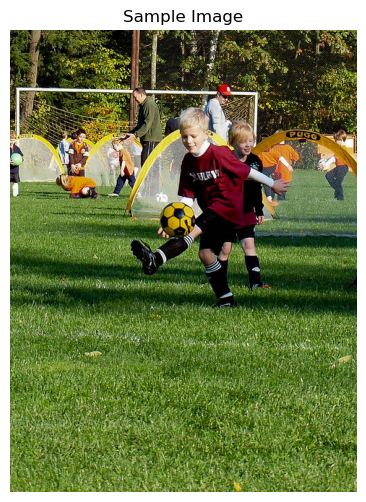

Captions:
- Trên sân cỏ , một cậu bé đang giơ chân lên để đá quả bóng .
- Một cậu bé đang đá quả bóng trong khi một cậu bé khác đang đứng ở phía sau .
- Một nhóm người đang chơi đùa trên sân cỏ .
- Trên sân cỏ , hai cầu thủ bóng đá đang luyện tập .
- Trên sân cỏ , một cầu thủ đang giơ chân lên để đá quả bóng .


In [5]:
# Display a sample image and its captions
sample_image = next(iter(image_dir.glob("*")), None)

if sample_image:
    sample_captions = captions[captions["image_name"] == sample_image.name]["caption"].tolist()
    
    # Display the sample image
    plt.figure(figsize=(8, 6))
    image = Image.open(sample_image)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Sample Image")
    plt.show()

    # Print the captions
    print("Captions:")
    for caption in sample_captions:
        print(f"- {caption}")
else:
    print("No images found in the dataset.")

In [6]:
# Check missing values (images with < 3 captions)
caption_counts = captions["image_name"].value_counts()
missing_captions = caption_counts[caption_counts < 3]
print(f"Images with fewer than 3 captions: {len(missing_captions)}")

Images with fewer than 3 captions: 0


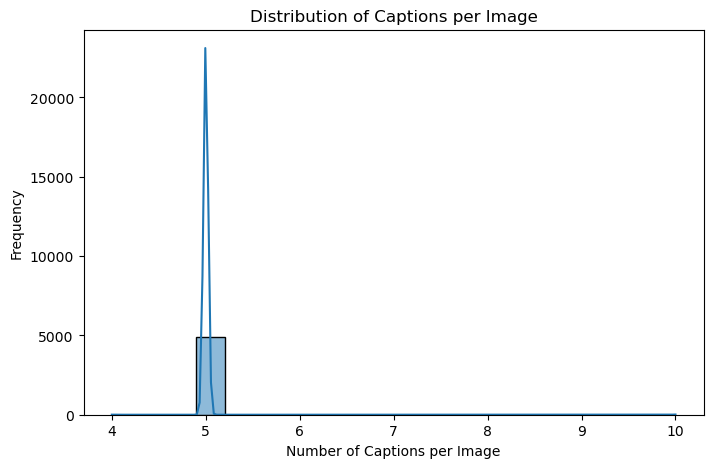

In [7]:
# Plot distribution of number of captions per image
plt.figure(figsize=(8, 5))
sns.histplot(caption_counts, bins=20, kde=True)
plt.xlabel("Number of Captions per Image")
plt.ylabel("Frequency")
plt.title("Distribution of Captions per Image")
plt.show()

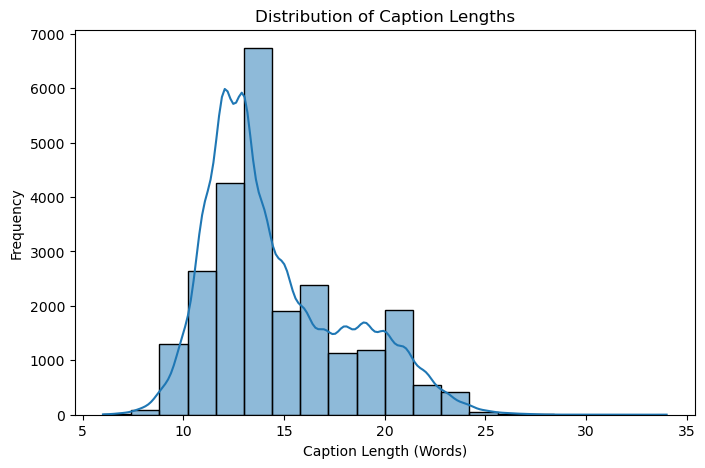

In [8]:
# Plot distribution of caption length
captions["caption_length"] = captions["caption"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 5))
sns.histplot(captions["caption_length"], bins=20, kde=True)
plt.xlabel("Caption Length (Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Caption Lengths")
plt.show()

In [9]:
# Check if all image paths are valid
invalid_images = [img for img in captions["image_name"].unique() if not (image_dir / img).exists()]
print(f"Number of missing image files: {len(invalid_images)}")

Number of missing image files: 0


## 📌 Summary & Next Steps

### Summary:
- Collected data from Pinterest (crawling + GPT-4o-mini captioning) and UIT-ViIC (pre-existing dataset).
- Organized and stored the dataset in US-Capydata-ViSportIC.
- Initial inspection results:
    - Total images: 4,923
    - Total captions: 24,633
    - No missing images or captions with fewer than 3 descriptions.

### Next Steps:
- Data preprocessing (normalize captions, remove duplicates...).
- In-depth data exploration (caption length analysis, outlier detection).
- Prepare a pipeline for Image Captioning model training.